# 1. 기본설정
## (1) 라이브러리

In [167]:
import time
start_time = time.time()

import os
import pandas as pd
import numpy as np
import tensorflow as tf

from PIL import Image
from PIL import ImageFilter
from matplotlib import pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, concatenate
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

from sklearn.cluster import KMeans

## (2) 파라미터 설정

In [30]:
image_size = 5
class_num = 3
is_filter_concat = False

blur_filter = False
contour_filter = False
edge_enhance_filter = True

filter_num = 0

if blur_filter == True:
    filter_num += 1
if contour_filter == True:
    filter_num += 1
if edge_enhance_filter == True:
    filter_num += 1

tts_test_size = 0.2
train_test_split_randomstate = 5

classifier_random_state = 32


## (3) 데이터 로드

In [4]:
data_dir = 'C:/Users/User/Google 드라이브/AIFFEL/+Final project/data/'
data_path1 = os.path.join(data_dir, 'prep_data_5x5_4.csv')
data1 = pd.read_csv(data_path1)
data_path2 = os.path.join(data_dir, 'prep_data_5x5_5.csv')
data2 = pd.read_csv(data_path2)
data_path3 = os.path.join(data_dir, 'prep_data_5x5_6.csv')
data3 = pd.read_csv(data_path3)
data = pd.concat([data1, data2, data3])
data.shape

(150, 27)

In [5]:
data = data.drop(['Unnamed: 0'], axis = 1)
data.head(10)

,FSR1,FSR2,FSR3,FSR4,FSR5,FSR9,FSR10,FSR11,FSR12,FSR13,...,FSR26,FSR27,FSR28,FSR29,FSR33,FSR34,FSR35,FSR36,FSR37,Label
0,0,160,0,0,0,0,0,32,0,0,...,0,0,0,0,0,0,0,0,27,4
1,0,164,0,0,0,0,0,36,0,0,...,0,0,0,19,0,0,0,0,32,4
2,0,122,0,0,0,0,23,39,0,0,...,0,0,0,59,0,0,0,0,37,4
3,0,170,0,0,0,0,17,41,0,0,...,0,0,0,46,0,0,0,0,28,4
4,0,187,0,0,0,0,18,40,0,0,...,0,0,0,37,0,0,0,0,33,4
5,0,187,0,0,0,0,16,36,0,0,...,0,0,0,38,0,0,0,0,34,4
6,0,201,0,0,0,0,0,32,0,0,...,0,0,0,35,0,0,0,0,27,4
7,0,210,0,0,0,0,0,32,0,0,...,0,0,0,44,0,0,0,0,22,4
8,0,216,0,0,0,0,20,41,0,0,...,0,0,0,45,0,0,0,0,25,4
9,0,221,0,0,0,0,0,31,0,0,...,0,0,0,27,0,0,0,0,23,4


In [6]:
feature = data.iloc[:,:-1]
label = data.iloc[:, -1]
print(feature.shape)
print(label.shape)

(150, 25)
(150,)


In [7]:
temp_array_feature = feature.to_numpy()

list_feature = []
for i in range(len(temp_array_feature)):
    reshaped_array = temp_array_feature[i].reshape(5,5)
    list_feature.append(reshaped_array)
    
array_feature = np.array(list_feature)
array_feature = array_feature.astype('uint8')
array_feature.shape

(150, 5, 5)

In [8]:
array_feature[0]

array([[  0, 160,   0,   0,   0],
       [  0,   0,  32,   0,   0],
       [  0,  30,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  27]], dtype=uint8)

데이터 이미지화


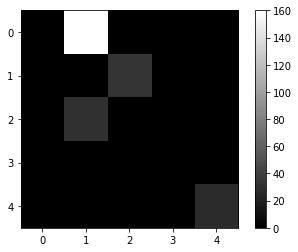

In [9]:
print('데이터 이미지화')
plt.imshow(array_feature[0] , cmap='gray')
plt.colorbar();

# 2. 데이터 전처리
## (1) Augmentation

In [10]:
# array_feature에 filter augmented data를 concatenate.
def filter_concat(array_feature, blur_filter = False, contour_filter = False, 
                  edge_enhance_filter = False):
    
    filteradded_array_feature = []
    
    for i, j in enumerate(array_feature):
        image = Image.fromarray(array_feature[i])
        stack_array = np.expand_dims(array_feature[i], axis = 2)
        
        if blur_filter:
            image_BLUR = image.filter(ImageFilter.BLUR)
            blur_array_feature = np.array(image_BLUR)
            blur_stack_array = np.expand_dims(blur_array_feature, axis = 2)
            stack_array = np.concatenate((stack_array, blur_stack_array), axis = 2)
            
        if contour_filter:
            image_CONTOUR = image.filter(ImageFilter.CONTOUR)
            contour_array_feature = np.array(image_CONTOUR)
            contour_stack_array = np.expand_dims(contour_array_feature, axis = 2)
            stack_array = np.concatenate((stack_array, contour_stack_array), axis = 2)
            
        if edge_enhance_filter:
            image_EDGE_ENHANCE = image.filter(ImageFilter.EDGE_ENHANCE)
            edge_enhance_array_feature = np.array(image_EDGE_ENHANCE)
            edge_enhance_stack_array = np.expand_dims(edge_enhance_array_feature, axis = 2)
            stack_array = np.concatenate((stack_array, edge_enhance_stack_array), axis = 2)
    
        filteradded_array_feature.append(stack_array)
    
    filteradded_array_feature = np.array(filteradded_array_feature)
    return filteradded_array_feature
    


In [11]:
final_feature = filter_concat(array_feature, blur_filter = blur_filter, contour_filter = contour_filter, 
                  edge_enhance_filter = edge_enhance_filter)

final_feature.shape

(150, 5, 5, 2)

## (3) 데이터 분리

In [88]:
X_train, X_test, y_train, y_test = train_test_split(final_feature, label, 
                                                    test_size = tts_test_size, random_state= train_test_split_randomstate)    ## test_size를 변경하며 시험.
# Normalization
X_train = X_train / 255.0
X_test = X_test / 255.0

# BATCH_SIZE = 64
# SHUFFLE_BUFFER_SIZE = 100

# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
X_train.shape

(120, 5, 5, 2)

In [89]:
sample_input_1d_train = data.iloc[0:120]
sample_input_1d_test = data.iloc[120:]
sample_input_1d.shape

(120, 26)

# 3. 모델 학습

# (1) 모델 설계

In [90]:
# concat_VGG16

# 1st block
image_input = Input(shape = (image_size, image_size, filter_num+1), name = 'Image Input')
x = Conv2D(64, (3,3), activation = 'relu', padding = 'same', name = 'block1_conv1')(image_input)
x = Conv2D(64, (3,3), activation = 'relu', padding = 'same', name = 'block1_conv2')(x)
x = MaxPool2D((2,2), strides = (2,2), name = 'block1_pool')(x)

# 2nd block
x = Conv2D(128, (3,3), activation = 'relu', padding = 'same', name = 'block2_conv1')(x)
x = Conv2D(128, (3,3), activation = 'relu', padding = 'same', name = 'block2_conv2')(x)
x = MaxPool2D((2,2), strides = (2,2), name = 'block2_pool')(x)

# 3rd block
# x = Conv2D(256, (3,3), activation = 'relu', padding = 'same', name = 'block3_conv1')(x)
# x = Conv2D(256, (3,3), activation = 'relu', padding = 'same', name = 'block3_conv2')(x)
# x = Conv2D(256, (3,3), activation = 'relu', padding = 'same', name = 'block3_conv3')(x)
# x = MaxPool2D((2,2), strides = (2,2), name = 'block3_pool')(x)

# 4th block
# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block4_conv1')(x)
# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block4_conv2')(x)
# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block4_conv3')(x)
# x = MaxPool2D((2,2), strides = (2,2), name = 'block4_pool')(x)

# 5th block
# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block5_conv1')(x)
# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block5_conv2')(x)
# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block5_conv3')(x)
# x = MaxPool2D((2,2), strides = (2,2), name = 'block5_pool')(x)

# Concatenation block
x = Flatten(name = 'flatten')(x)
feature_input = Input(shape = (len(sample_input_1d_train.columns)), name = 'Feature Input')
concat = concatenate([x, feature_input])

# Final block
x = Dense(4096, activation = 'relu', name = 'fc1')(concat)
out = Dense(4096, activation = 'relu', name = 'fc2')(x)
classes_num = 3
prediction = Dense(classes_num, activation = 'softmax', name = 'prediction')(out)
concat_VGG16_model = Model(inputs = [image_input, feature_input], outputs = prediction, name = 'concat_VGG16_model')
    

# VGG16_model = Model(name = 'VGG-16', inputs = img_input, outputs = x)

concat_VGG16_model.summary()

Model: "concat_VGG16_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image Input (InputLayer)       [(None, 5, 5, 2)]    0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 5, 5, 64)     1216        ['Image Input[0][0]']            
                                                                                                  
 block1_conv2 (Conv2D)          (None, 5, 5, 64)     36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 2, 2, 64)     0           ['block1_conv2[0][0]']           
                                                                                 

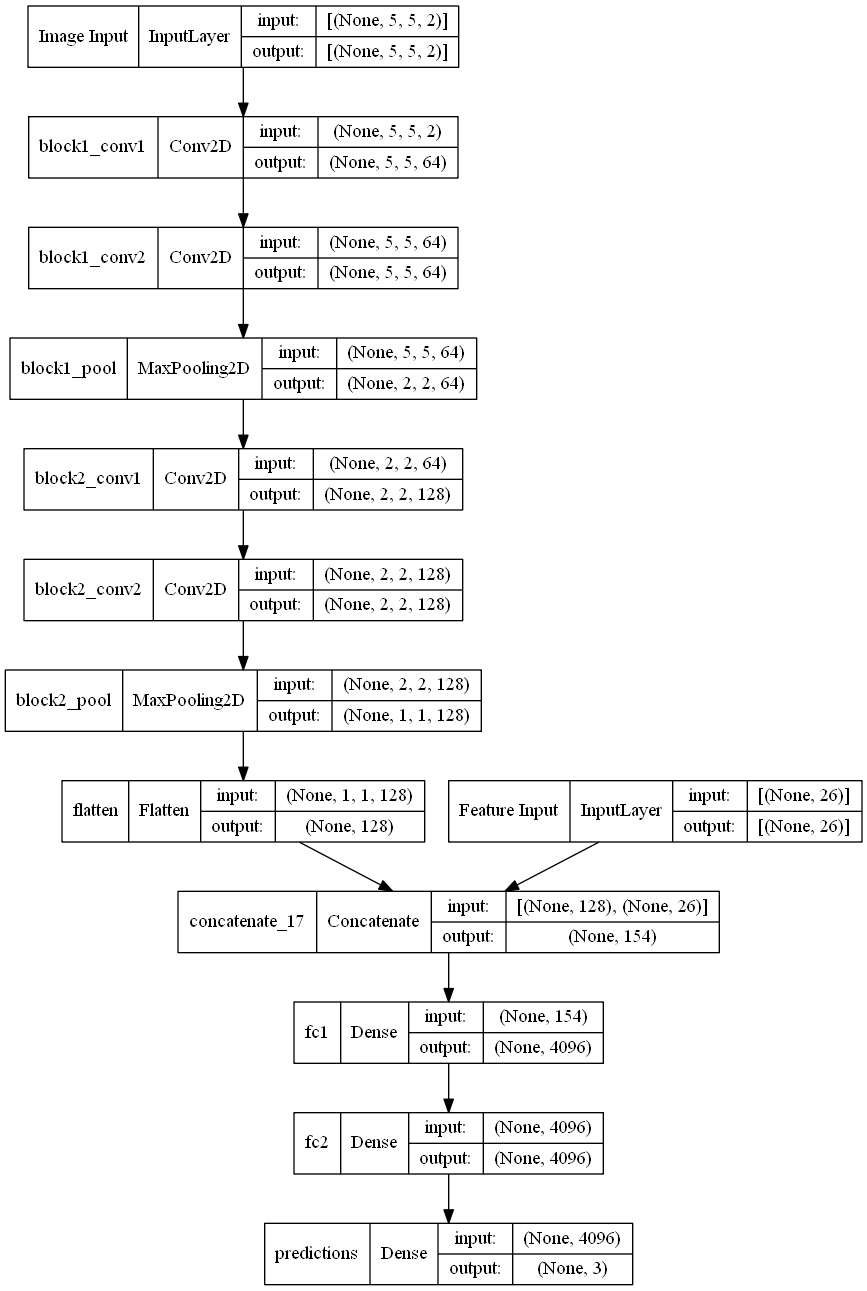

In [94]:
plot_model(concat_VGG16_model, 'concat_VGG16_model.png', show_shapes = True)

In [91]:
# 모델 학습
concat_VGG16_model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

concat_VGG16_model.fit([X_train, sample_input_1d_train], y_train, epochs = 5)

concat_VGG16_model.evaluate([X_test, sample_input_1d_test], y_test, verbose = 2)

Epoch 1/5
4/4 [==============================] - 0s 26ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 2/5
4/4 [==============================] - 0s 12ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/5
4/4 [==============================] - 0s 12ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/5
4/4 [==============================] - 0s 11ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/5
4/4 [==============================] - 0s 11ms/step - loss: nan - accuracy: 0.0000e+00
1/1 - 0s - loss: nan - accuracy: 0.0000e+00 - 92ms/epoch - 92ms/step


[nan, 0.0]

In [108]:
concat_VGG16_features_list = [layer.output for layer in concat_VGG16_model.layers]
concat_VGG16_features_list

[<KerasTensor: shape=(None, 5, 5, 2) dtype=float32 (created by layer 'Image Input')>,
 <KerasTensor: shape=(None, 5, 5, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 5, 5, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 2, 2, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 2, 2, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 2, 2, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 1, 1, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 26) dtype=float32 (created by layer 'Feature Input')>,
 <KerasTensor: shape=(None, 154) dtype=float32 (created by layer 'concatenate_17')>,
 <KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'fc1')>,
 <KerasTensor: shape=(None, 4096) dtype=float32 (created by laye

In [110]:
concat_VGG16_feat_extraction_model = Model(inputs = concat_VGG16_model.input, outputs = concat_VGG16_features_list)
concat_VGG16_extracted_features = concat_VGG16_feat_extraction_model([X_train, sample_input_1d_train])
concat_VGG16_extracted_features

[<tf.Tensor: shape=(120, 5, 5, 2), dtype=float32, numpy=
 array([[[[0.        , 0.        ],
          [0.99607843, 0.99607843],
          [0.        , 0.        ],
          [0.        , 0.        ],
          [0.        , 0.        ]],
 
         [[0.        , 0.        ],
          [0.        , 0.        ],
          [0.        , 0.        ],
          [0.        , 0.        ],
          [0.        , 0.        ]],
 
         [[0.        , 0.        ],
          [0.07843138, 0.39215687],
          [0.        , 0.        ],
          [0.        , 0.        ],
          [0.        , 0.        ]],
 
         [[0.        , 0.        ],
          [0.        , 0.        ],
          [0.        , 0.        ],
          [0.        , 0.        ],
          [0.16470589, 0.16470589]],
 
         [[0.        , 0.        ],
          [0.        , 0.        ],
          [0.        , 0.        ],
          [0.        , 0.        ],
          [0.09019608, 0.09019608]]],
 
 
        [[[0.7254902 , 0.

In [97]:
# Simpler_VGG16

img_input = Input(shape = (image_size, image_size, filter_num+1), name = 'Image input')
x = Conv2D(64, (3,3), activation = 'relu', padding = 'same', name = 'block1_conv1')(img_input)
x = Conv2D(64, (3,3), activation = 'relu', padding = 'same', name = 'block1_conv2')(x)
x = MaxPool2D((2,2), strides = (2,2), name = 'block1_pool')(x)
print('1st block')

x = Conv2D(128, (3,3), activation = 'relu', padding = 'same', name = 'block2_conv1')(x)
x = Conv2D(128, (3,3), activation = 'relu', padding = 'same', name = 'block2_conv2')(x)
x = MaxPool2D((2,2), strides = (2,2), name = 'block2_pool')(x)
print('2nd block')

# x = Conv2D(256, (3,3), activation = 'relu', padding = 'same', name = 'block3_conv1')(x)
# x = Conv2D(256, (3,3), activation = 'relu', padding = 'same', name = 'block3_conv2')(x)
# x = Conv2D(256, (3,3), activation = 'relu', padding = 'same', name = 'block3_conv3')(x)
# x = MaxPool2D((2,2), strides = (2,2), name = 'block3_pool')(x)
# print('3rd block')

# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block4_conv1')(x)
# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block4_conv2')(x)
# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block4_conv3')(x)
# x = MaxPool2D((2,2), strides = (2,2), name = 'block4_pool')(x)
# print('4th block')

# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block5_conv1')(x)
# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block5_conv2')(x)
# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block5_conv3')(x)
# x = MaxPool2D((2,2), strides = (2,2), name = 'block5_pool')(x)
# print('5th block')

x = Flatten(name = 'flatten')(x)
x = Dense(4096, activation = 'relu', name = 'fc1')(x)
output = Dense(4096, activation = 'relu', name = 'fc2')(x)

print('6th block')

classes = 3
prediction = Dense(classes, activation = 'softmax', name = 'prediction')(output)

simpler_VGG16_model = Model(name = 'simpler_VGG16', inputs = img_input, outputs = prediction)

simpler_VGG16_model.summary()

1st block
2nd block
6th block
Model: "simpler_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image input (InputLayer)    [(None, 5, 5, 2)]         0         
                                                                 
 block1_conv1 (Conv2D)       (None, 5, 5, 64)          1216      
                                                                 
 block1_conv2 (Conv2D)       (None, 5, 5, 64)          36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 2, 2, 64)          0         
                                                                 
 block2_conv1 (Conv2D)       (None, 2, 2, 128)         73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 2, 2, 128)         147584    
                                                                 
 block2_pool (MaxPoolin

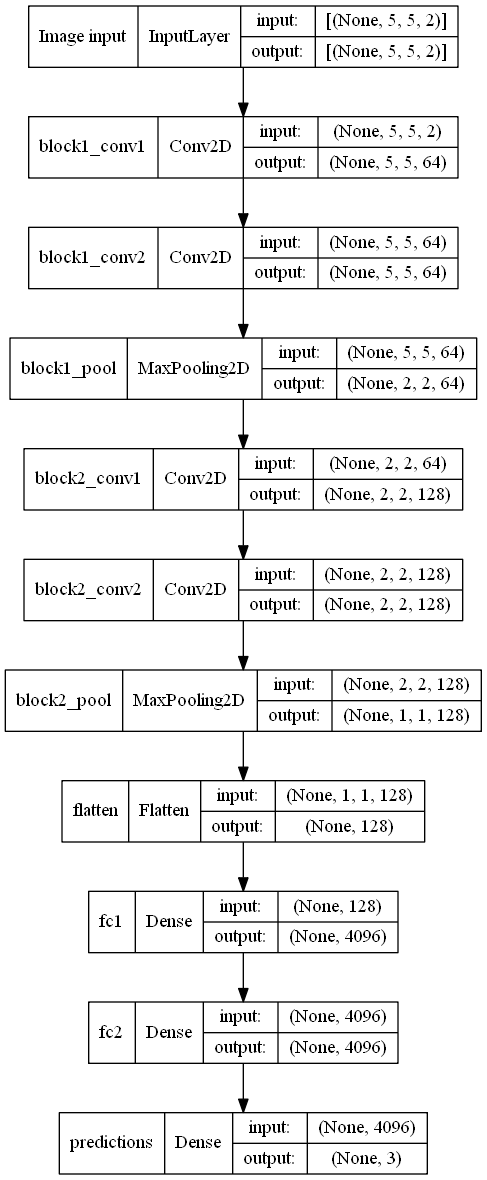

In [98]:
plot_model(simpler_VGG16_model, 'simpler_VGG16_model.png', show_shapes = True)

In [87]:
# 모델 학습
simpler_VGG16_model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

simpler_VGG16_model.fit(X_train, y_train, epochs = 5)

simpler_VGG16_model.evaluate(X_test, y_test, verbose = 2)

Epoch 1/5
4/4 [==============================] - 1s 58ms/step - loss: 7.0911 - accuracy: 0.3250
Epoch 2/5
4/4 [==============================] - 0s 9ms/step - loss: 0.2394 - accuracy: 0.9000
Epoch 3/5
4/4 [==============================] - 0s 9ms/step - loss: 0.0092 - accuracy: 1.0000
Epoch 4/5
4/4 [==============================] - 0s 9ms/step - loss: 1.9878e-04 - accuracy: 1.0000
Epoch 5/5
4/4 [==============================] - 0s 9ms/step - loss: 2.0812e-06 - accuracy: 1.0000
1/1 - 0s - loss: 7.1526e-08 - accuracy: 1.0000 - 88ms/epoch - 88ms/step


[7.152552683464819e-08, 1.0]

In [103]:
simpler_VGG16_features_list = [layer.output for layer in simpler_VGG16_model.layers]
simpler_VGG16_features_list

[<KerasTensor: shape=(None, 5, 5, 2) dtype=float32 (created by layer 'Image input')>,
 <KerasTensor: shape=(None, 5, 5, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 5, 5, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 2, 2, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 2, 2, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 2, 2, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 1, 1, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'fc1')>,
 <KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'fc2')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'predictions')>]

In [163]:
simpler_VGG16_feat_extraction_model = Model(inputs = simpler_VGG16_model.input, outputs = simpler_VGG16_features_list)
train_simpler_VGG16_extracted_features = simpler_VGG16_feat_extraction_model(X_train)
test_simpler_VGG16_extracted_features = simpler_VGG16_feat_extraction_model(X_test)

In [164]:
train_simpler_VGG16_representations = np.array(train_simpler_VGG16_extracted_features[-2], dtype = object)
test_simpler_VGG16_representations = np.array(test_simpler_VGG16_extracted_features[-2], dtype = object)

In [157]:
representations

(120, 4096)

In [154]:
len(simpler_VGG16_extracted_features)

11

In [155]:
simpler_VGG16_extracted_features[-1]

<tf.Tensor: shape=(120, 3), dtype=float32, numpy=
array([[0.3340083 , 0.33383116, 0.33216053],
       [0.33432582, 0.33394375, 0.33173037],
       [0.33437085, 0.33389747, 0.33173162],
       [0.3338736 , 0.33380312, 0.3323233 ],
       [0.3344234 , 0.33393192, 0.3316447 ],
       [0.3339729 , 0.33382985, 0.33219725],
       [0.33400398, 0.33363712, 0.33235893],
       [0.33356366, 0.33360067, 0.33283567],
       [0.33397305, 0.33381227, 0.33221465],
       [0.33356813, 0.3336227 , 0.33280918],
       [0.33359614, 0.33366948, 0.3327344 ],
       [0.33424446, 0.3339269 , 0.33182868],
       [0.33386606, 0.33380485, 0.33232906],
       [0.33399016, 0.33364055, 0.3323693 ],
       [0.33440903, 0.33385825, 0.33173275],
       [0.33358997, 0.33366033, 0.3327497 ],
       [0.33426207, 0.33393127, 0.3318067 ],
       [0.33357757, 0.333645  , 0.33277744],
       [0.3335555 , 0.3336076 , 0.33283687],
       [0.33392864, 0.33378372, 0.33228767],
       [0.33361334, 0.33363092, 0.33275577],
     

## (2) 분류 예측

In [165]:

# Decision tree
DT_classifier = DecisionTreeClassifier(random_state = classifier_random_state)   ## 모델 지정
DT_classifier.fit(train_simpler_VGG16_representations, y_train)
# DT_classifier.fit(concat_VGG16_extracted_features, y_train)

# Random forest
RF_classifier = RandomForestClassifier(random_state = classifier_random_state)   ## 모델 지정
RF_classifier.fit(train_simpler_VGG16_representations, y_train)
# RF_classifier.fit(X_train, y_train)

# Support vector machine
SVM_classifier = svm.SVC(random_state = classifier_random_state)   ## 모델 지정
SVM_classifier.fit(train_simpler_VGG16_representations, y_train)
# SVM_classifier.fit(X_train, y_train)

# Stochastic gradient descent
SGD_classifier = SGDClassifier(random_state = classifier_random_state)   ## 모델 지정
SGD_classifier.fit(train_simpler_VGG16_representations, y_train)
# SGD_classifier.fit(X_train, y_train)

# Logistic regression
LR_classifier = LogisticRegression(random_state = classifier_random_state, max_iter = 5000)   ## 모델 지정
LR_classifier.fit(train_simpler_VGG16_representations, y_train)
# LR_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=5000, random_state=32)

In [166]:
DT_y_pred = DT_classifier.predict(test_simpler_VGG16_representations)
DT_report = classification_report(y_test, DT_y_pred)
print(DT_report)

RF_y_pred = RF_classifier.predict(test_simpler_VGG16_representations)
RF_report = classification_report(y_test, RF_y_pred)
print(RF_report)

SVM_y_pred = SVM_classifier.predict(test_simpler_VGG16_representations)
SVM_report = classification_report(y_test, SVM_y_pred)
print(SVM_report)

SGD_y_pred = SGD_classifier.predict(test_simpler_VGG16_representations)
SGD_report = classification_report(y_test, SGD_y_pred)
print(SGD_report)

LR_y_pred = LR_classifier.predict(test_simpler_VGG16_representations)
LR_report = classification_report(y_test, LR_y_pred)
print(LR_report)

              precision    recall  f1-score   support

           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

              precision    recall  f1-score   support

           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

              precision    recall  f1-score   support

           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        11

    accuracy        

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [172]:
from sklearn.semi_supervised import LabelSpreading
k3_fit_ls_labeled = (LabelSpreading(kernel='knn', n_neighbors=3).fit(train_simpler_VGG16_representations, y_train))


In [176]:
print(y_test.shape)
print(k3_pred_ls_labeled.shape)

(30,)
(30,)


In [185]:
from sklearn.metrics import f1_score
k3_pred_ls_labeled = k3_fit_ls_labeled.predict(test_simpler_VGG16_representations)
k3_f1_ls_labeled = f1_score(y_test, k3_pred_ls_labeled, average='micro')
k3_f1_ls_labeled

1.0

In [170]:
train_simpler_VGG16_representations.shape

(120, 4096)

In [178]:
from sklearn.naive_bayes import MultinomialNB
clf= MultinomialNB()
clf.fit(train_simpler_VGG16_representations, y_train)
score = clf.score(test_simpler_VGG16_representations, y_test)
score

0.3

In [180]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(test_simpler_VGG16_representations)
print(confusion_matrix(y_test,y_pred))

[[ 8  0  0]
 [10  1  0]
 [11  0  0]]


In [187]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print("Precision Score : ",precision_score(y_test,y_pred, average='micro'))
# print("Precision Score : ",precision_score(y_test,y_pred,pos_label='positive', average='micro'))
print("Recall Score :" , recall_score(y_test, y_pred, average='micro'))
# print("Recall Score :" , recall_score(y_test, y_pred, pos_label='positive', average='micro'))

Precision Score :  0.3
Recall Score : 0.3


In [169]:
# 클러스터 레이블을 추출.
target_cluster_num = 3
kmeans = KMeans(n_clusters=target_cluster_num, random_state=10).fit(train_simpler_VGG16_representations)

cluster_label = kmeans.predict(test_simpler_VGG16_representations)

print('슝~')

AttributeError: 'NoneType' object has no attribute 'split'

In [39]:
inputs_2d = Input(shape = (image_size, image_size, filter_num+1), name = 'Image input')
x1 = Conv2D(32, 3, activation = 'relu')(inputs_2d) # 입력을 받아 연산.
x2 = Conv2D(64, 3, activation = 'relu')(x1)    # 1차 중간 출력을 받아 연산.
x3 = Flatten()(x2)    # 2차 중간 출력을 받아 연산.
x4 = Dense(128, activation = 'relu')(x3)    # 3차 중간 출력을 받아 연산.
predictions = Dense(8, activation = 'softmax')(x4)
plain_model = Model(inputs = inputs_2d, outputs = predictions)
plain_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image input (InputLayer)    [(None, 5, 5, 2)]         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 3, 3, 32)          608       
                                                                 
 conv2d_15 (Conv2D)          (None, 1, 1, 64)          18496     
                                                                 
 flatten_7 (Flatten)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 128)               8320      
                                                                 
 dense_19 (Dense)            (None, 8)                 1032      
                                                                 
Total params: 28,456
Trainable params: 28,456
Non-trainable

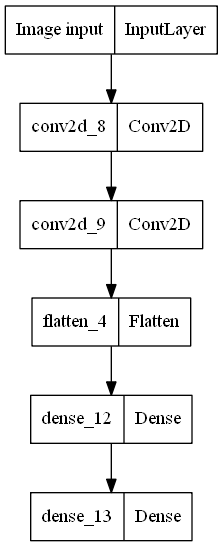

In [32]:
plot_model(plain_model)

In [40]:
# 모델 학습
plain_model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

# model.fit([X_train, aux_train], y_train, epochs = 5)
plain_model.fit(X_train, y_train, epochs = 5)

plain_model.evaluate(X_test, y_test, verbose = 2)

Epoch 1/5
4/4 [==============================] - 0s 4ms/step - loss: 1.3730 - accuracy: 0.7000
Epoch 2/5
4/4 [==============================] - 0s 6ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 3/5
4/4 [==============================] - 0s 5ms/step - loss: 3.8301e-04 - accuracy: 1.0000
Epoch 4/5
4/4 [==============================] - 0s 4ms/step - loss: 9.6368e-05 - accuracy: 1.0000
Epoch 5/5
4/4 [==============================] - 0s 5ms/step - loss: 2.4693e-05 - accuracy: 1.0000
1/1 - 0s - loss: 1.2791e-05 - accuracy: 1.0000 - 94ms/epoch - 94ms/step


[1.2790607797796838e-05, 1.0]

In [ ]:
inputs_2d_concat = Input(shape = (image_size, image_size, filter_num+1), name = 'Image input')
inputs_1d = Input(shape = len(sample_input_1d_train.columns), name = 'Feature_Input')
concat_x1 = Conv2D(32, 3, activation = 'relu', name = '1st Conv2D')(inputs_2d_concat) # 입력을 받아 연산.
concat_x2 = Conv2D(64, 3, activation = 'relu', name = '2st Conv2D')(concat_x1)    # 1차 중간 출력을 받아 연산.
concat_x3 = Flatten()(concat_x2)    # 2차 중간 출력을 받아 연산.
concat = concatenate([concat_x3, inputs_1d])
x_concat = Dense(128, activation = 'relu')(concat)
predictions_concat = Dense(10, activation = 'softmax')(x_concat)
concat_model = Model(inputs = [inputs_2d_concat, inputs_1d], outputs = predictions_concat)
plot_model(concat_model)

In [101]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.inputs = Input(shape = (5, 5, 2))
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.conv2 = Conv2D(64, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation = 'softmax')

  def call(self, x):
    x = self.inputs(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

inputs = image_input
outputs = MyModel()(inputs)
custom_model = Model(inputs, outputs)

# model = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=(5, 5)),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(10)
# ])

TypeError: Exception encountered when calling layer "my_model_1" (type MyModel).

in user code:

    File "C:\Users\user\AppData\Local\Temp/ipykernel_9924/1980236340.py", line 12, in call  *
        x = self.inputs(x)

    TypeError: 'KerasTensor' object is not callable


Call arguments received:
  • x=tf.Tensor(shape=(None, 5, 5, 2), dtype=float32)

In [ ]:
print(X_train.shape)
print()

In [61]:
# 모델 학습
concat_model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])
concat_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image input (InputLayer)       [(None, 5, 5, 2)]    0           []                               
                                                                                                  
 conv2d_22 (Conv2D)             (None, 3, 3, 32)     608         ['Image input[0][0]']            
                                                                                                  
 conv2d_23 (Conv2D)             (None, 1, 1, 64)     18496       ['conv2d_22[0][0]']              
                                                                                                  
 flatten_11 (Flatten)           (None, 64)           0           ['conv2d_23[0][0]']              
                                                                                           

In [59]:
# model.fit([X_train, aux_train], y_train, epochs = 5)
concat_model.fit([X_train, sample_input_1d_train], y_train, epochs = 5)

concat_model.evaluate([X_test, sample_input_1d_test], y_test, verbose = 2)

Epoch 1/5
4/4 [==============================] - 0s 6ms/step - loss: 16.0746 - accuracy: 0.1333
Epoch 2/5
4/4 [==============================] - 0s 6ms/step - loss: 1.0412 - accuracy: 0.7833
Epoch 3/5
4/4 [==============================] - 0s 4ms/step - loss: 0.0615 - accuracy: 0.9750
Epoch 4/5
4/4 [==============================] - 0s 5ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 5/5
4/4 [==============================] - 0s 6ms/step - loss: 9.5754e-05 - accuracy: 1.0000
1/1 - 0s - loss: 1.1921e-07 - accuracy: 1.0000 - 89ms/epoch - 89ms/step


[1.1920916875851617e-07, 1.0]

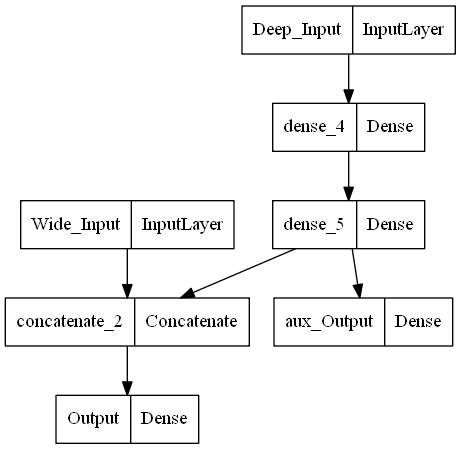

In [23]:
input_a = Input(shape=[1], name="Wide_Input")
input_b = Input(shape=[1], name="Deep_Input")
# define deep path
hidden_1 = Dense(30, activation="relu")(input_b)
hidden_2 = Dense(30, activation="relu")(hidden_1)
# define merged path
concat = concatenate([input_a, hidden_2])
output = Dense(1, name="Output")(concat)
# define another output for the deep path
aux_output = Dense(1,name="aux_Output")(hidden_2)
# build the model
model = Model(inputs=[input_a, input_b], outputs=[output, aux_output])
# visualize the architecture
plot_model(model)


In [26]:
# encapsuling into a class
class WideAndDeepModel(Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super(WideAndDeepModel, self).__init__()
        self.hidden1 = Dense(units, activation=activation)
        self.hidden2 = Dense(units, activation=activation)
        self.main_output = Dense(1)
        self.aux_output = Dense(1)
    def call(self, inputs):
        input_a, input_b = inputs
        hidden1 = self.hidden1(input_b)
        hidden2 = self.hidden2(hidden2)
        concat = concatenate([input_a, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

sample_model = WideAndDeepModel()

In [27]:
plot_model(sample_model)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
# inputs = keras.Input(shape = (5, 5, 1))
# x = keras.layers.Conv2D(32, 3, activation = 'relu')(inputs) # 입력을 받아 연산.
# x = keras.layers.Conv2D(64, 3, activation = 'relu')(x)    # 1차 중간 출력을 받아 연산.
# x = keras.layers.Flatten()(x)    # 2차 중간 출력을 받아 연산.
# x = keras.layers.Dense(128, activation = 'relu')(x)    # 3차 중간 출력을 받아 연산.

# auxiliary_input = keras.Input(shape=(300,), name='aux_input')
# auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(x)
# x = keras.layers.Concatenate(axis=1)([x, auxiliary_input])
# predictions = keras.layers.Dense(10, activation = 'softmax')(x)    # 4차 중간 출력을 받아 연산. 최종.

# model = keras.Model(inputs = [inputs,auxiliary_input], outputs = predictions)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
# model.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])
#               metrics=['accuracy'])

model.summary()

In [ ]:
model.fit(train_dataset, epochs=10)

In [117]:
a = tf.constant(concat_VGG16_extracted_features)
a

ValueError: TypeError: Scalar tensor has no `len()`
Traceback (most recent call last):

  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1096, in __len__
    raise TypeError("Scalar tensor has no `len()`")

TypeError: Scalar tensor has no `len()`



In [113]:
concat_VGG16_extracted_features = np.asarray(concat_VGG16_extracted_features)

C:\Users\user\AppData\Local\Temp/ipykernel_9924/1630188664.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  concat_VGG16_extracted_features = np.asarray(concat_VGG16_extracted_features)


ValueError: could not broadcast input array from shape (120,5,5,2) into shape (120,)

In [111]:

# Decision tree
DT_classifier = DecisionTreeClassifier(random_state = classifier_random_state)   ## 모델 지정
DT_classifier.fit(concat_VGG16_extracted_features, y_train)

# Random forest
RF_classifier = RandomForestClassifier(random_state = classifier_random_state)   ## 모델 지정
RF_classifier.fit(X_train, y_train)

# Support vector machine
SVM_classifier = svm.SVC(random_state = classifier_random_state)   ## 모델 지정
SVM_classifier.fit(X_train, y_train)

# Stochastic gradient descent
SGD_classifier = SGDClassifier(random_state = classifier_random_state)   ## 모델 지정
SGD_classifier.fit(X_train, y_train)

# Logistic regression
LR_classifier = LogisticRegression(random_state = classifier_random_state, max_iter = 5000)   ## 모델 지정
LR_classifier.fit(X_train, y_train)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (13, 120) + inhomogeneous part.

# 4. 예측 및 결과 비교

In [ ]:
DT_y_pred = DT_classifier.predict(X_test)
DT_report = classification_report(y_test, DT_y_pred)
print(DT_report)

In [ ]:
RF_y_pred = RF_classifier.predict(X_test)
RF_report = classification_report(y_test, RF_y_pred)
print(RF_report)

In [ ]:
SVM_y_pred = SVM_classifier.predict(X_test)
SVM_report = classification_report(y_test, SVM_y_pred)
print(SVM_report)

In [ ]:
SGD_y_pred = SGD_classifier.predict(X_test)
SGD_report = classification_report(y_test, SGD_y_pred)
print(SGD_report)

In [ ]:
LR_y_pred = LR_classifier.predict(X_test)
LR_report = classification_report(y_test, LR_y_pred)
print(LR_report)

In [70]:
image_input = Input(shape = (5, 5, 1), name = 'Image Input')
x = Conv2D(64, (3,3), activation = 'relu', padding = 'same', name = 'block1_conv1')(img_input)
x = Conv2D(64, (3,3), activation = 'relu', padding = 'same', name = 'block1_conv2')(x)
x = MaxPool2D((2,2), strides = (2,2), name = 'block1_pool')(x)
print('1st block')

x = Conv2D(128, (3,3), activation = 'relu', padding = 'same', name = 'block2_conv1')(x)
x = Conv2D(128, (3,3), activation = 'relu', padding = 'same', name = 'block2_conv2')(x)
x = MaxPool2D((2,2), strides = (2,2), name = 'block2_pool')(x)
print('2nd block')

# x = Conv2D(256, (3,3), activation = 'relu', padding = 'same', name = 'block3_conv1')(x)
# x = Conv2D(256, (3,3), activation = 'relu', padding = 'same', name = 'block3_conv2')(x)
# x = Conv2D(256, (3,3), activation = 'relu', padding = 'same', name = 'block3_conv3')(x)
# x = MaxPool2D((2,2), strides = (2,2), name = 'block3_pool')(x)
# print('3rd block')

# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block4_conv1')(x)
# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block4_conv2')(x)
# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block4_conv3')(x)
# x = MaxPool2D((2,2), strides = (2,2), name = 'block4_pool')(x)
# print('4th block')

# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block5_conv1')(x)
# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block5_conv2')(x)
# x = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'block5_conv3')(x)
# x = MaxPool2D((2,2), strides = (2,2), name = 'block5_pool')(x)
# print('5th block')

x = Flatten(name = 'flatten')(x)
feature_input = Input(shape = (26), name = 'Feature Input')
concat = concatenate([x, feature_input])

x = Dense(4096, activation = 'relu', name = 'fc1')(concat)
x = Dense(4096, activation = 'relu', name = 'fc2')(x)
classes = 10
x = Dense(classes, activation = 'softmax', name = 'predictions')(x)
VGG16_concat_model = Model(inputs = [img_input, inputs_1d], outputs = x, name = 'VGG16_concat_model')
print('6th block')



# VGG16_model = Model(name = 'VGG-16', inputs = img_input, outputs = x)

VGG16_concat_model.summary()

1st block
2nd block
6th block
Model: "VGG16_concat_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image Input (InputLayer)       [(None, 5, 5, 1)]    0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 5, 5, 64)     640         ['Image Input[0][0]']            
                                                                                                  
 block1_conv2 (Conv2D)          (None, 5, 5, 64)     36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 2, 2, 64)     0           ['block1_conv2[0][0]']           
                                                   